# Introduction: New York City Taxi Fare Prediction 

The New York City Taxi Fare Prediction dataset is a challenge hosted by Kaggle in partnership with Google Cloud and Coursera. 
This dataset uses a selection from the massive New York City (NYC) Taxi and Limousine Commission (TLC) Yellow Cab dataset that is also publicly available on Big Query.

The goal of this project is to predict the fare amount of a taxi ride given the input features like pickup_datetime, pickup/dropoff latitude, pickup/dropoff longitude and number of passengers. This is a Supervised regression machine learning task. 

Competition Link -
https://www.kaggle.com/c/new-york-city-taxi-fare-prediction#description

This is a huge dataset consisting of 55M rows in the training set and 10k rows in the test set. The project has been divided into different phases and each phase covers a substantial amount of work. 

For **Phase1** out of 55M rows, we downsampled and utilized just 1 million rows. This phase covers the following tasks:
- Dropped the missing rows using dropna
- Removed the outliers in all the columns using percentile approach
- Created distance feature from the latitude/longitude columns
- Created features from pickup_datetime column
- Created class for Data cleanup and removal of outliers
- Created class for feature extraction
- Experimented with Linear Regression and Random forest algorithms for model evaluation
- Performed GridSearch and statistical significance tests
- Wrapped all the preparation and predictor steps in a pipeline


# Notebook Preparation

In [1]:
import dill

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import seaborn as sns
import warnings
warnings.simplefilter('ignore')

from collections import Counter
from scipy import sparse, stats
from sklearn import preprocessing as prep
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, ShuffleSplit, StratifiedKFold, KFold
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.svm import SVR
from sklearn.utils import check_array
#from sklearn_pandas import CategoricalImputer
from time import time

%matplotlib inline
plt.style.use('seaborn-whitegrid')

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, x_in, y=None):
        return self
    def transform(self, x_in):
        return x_in[self.attribute_names].values

In [3]:
# Set up reporting
import pandas as pd
results = pd.DataFrame(columns=["ExpID", "Train RMSE", "Test RMSE", "p-value","t-stat", "Train Time(s)", "Test Time(s)", "Experiment description"])

# Load Data

## Training Data

In [4]:
data = pd.read_csv('data/train.csv',parse_dates=["pickup_datetime"])

In [5]:
import feather
 
path = 'data/data.feather'
feather.write_dataframe(data, path)
#df = feather.read_dataframe(path)

In [6]:
data.shape

(55423856, 8)

In [7]:
df = feather.read_dataframe('data/data.feather')

In [8]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.542386e+07,5.542386e+07,5.542386e+07,5.542348e+07,5.542348e+07,5.542386e+07
mean,1.134505e+01,-7.250968e+01,3.991979e+01,-7.251121e+01,3.992068e+01,1.685380e+00
std,2.071083e+01,1.284888e+01,9.642353e+00,1.278220e+01,9.633346e+00,1.327664e+00
min,-3.000000e+02,-3.442060e+03,-3.492264e+03,-3.442025e+03,-3.547887e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073493e+01,-7.399140e+01,4.073403e+01,1.000000e+00
50%,8.500000e+00,-7.398180e+01,4.075265e+01,-7.398015e+01,4.075316e+01,1.000000e+00
75%,1.250000e+01,-7.396708e+01,4.076713e+01,-7.396367e+01,4.076810e+01,2.000000e+00
max,9.396336e+04,3.457626e+03,3.408790e+03,3.457622e+03,3.537133e+03,2.080000e+02


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55423856 entries, 0 to 55423855
Data columns (total 8 columns):
key                  object
fare_amount          float64
pickup_datetime      datetime64[ns]
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      int64
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 3.3+ GB


In [10]:
data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1


In [11]:
data.isnull().sum()

key                    0
fare_amount            0
pickup_datetime        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude    376
dropoff_latitude     376
passenger_count        0
dtype: int64

In [12]:
sampletrain = data.sample(10000)
sampletrain50k = data.sample(50000)
sampletrain100k = data.sample(100000)
sampletrain500k = data.sample(500000)
sampletrain1m = data.sample(1000000)

In [13]:
feather.write_dataframe(sampletrain, 'data/sampletrain.feather')
feather.write_dataframe(sampletrain50k, 'data/sampletrain50k.feather')
feather.write_dataframe(sampletrain100k, 'data/sampletrain100k.feather')
feather.write_dataframe(sampletrain500k, 'data/sampletrain500k.feather')
feather.write_dataframe(sampletrain1m, 'data/sampletrain1m.feather')

In [14]:
sampletrain50k.to_csv('data/sampletrain50k.csv')
sampletrain100k.to_csv('data/sampletrain100k.csv')
sampletrain500k.to_csv('data/sampletrain500k.csv')
sampletrain1m.to_csv('data/sampletrain1m.csv')

## Test Data

In [4]:
test = pd.read_csv('data/test.csv',parse_dates=["pickup_datetime"])

In [16]:
test.shape

(9914, 7)

In [17]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 7 columns):
key                  9914 non-null object
pickup_datetime      9914 non-null datetime64[ns]
pickup_longitude     9914 non-null float64
pickup_latitude      9914 non-null float64
dropoff_longitude    9914 non-null float64
dropoff_latitude     9914 non-null float64
passenger_count      9914 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 542.2+ KB


In [18]:
test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


In [19]:
test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12,-73.966046,40.789775,-73.988565,40.744427,1


# Exploratory Data Analysis and Preprocessing

## Downsample the data so that we can experiment more easily

Let's downsample the data by taking a random sample of 1million records from the training sets.

In [5]:
sampletrain = pd.read_csv('data/sampletrain1m.csv', parse_dates=["pickup_datetime"])

In [6]:
sampletrain.shape

(1000000, 9)

In [7]:
sampletrain.columns

Index(['Unnamed: 0', 'key', 'fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count'],
      dtype='object')

Remove the unnecessary columns from the dataset

In [8]:
sampletrain = sampletrain[['pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'fare_amount']]

In [9]:
sampletrain.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
0,2014-05-16 09:28:00,-73.938528,40.805310,-73.870817,40.773962,1,24.33
1,2011-10-14 15:21:55,0.000000,0.000000,0.000000,0.000000,1,12.90
2,2012-08-11 23:43:19,-73.969091,40.798644,-73.993477,40.757396,1,12.50
3,2014-12-04 20:41:26,-73.999625,40.733399,-73.987364,40.764521,1,14.50
4,2012-03-08 20:40:29,-73.980710,40.782418,-73.968085,40.793062,1,5.30


## Data Quality Check

In [10]:
sampletrain.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
count,1000000.000000,1000000.000000,999996.000000,999996.000000,1000000.000000,1000000.000000
mean,-72.494666,39.919985,-72.498725,39.912088,1.686277,11.336244
std,12.200565,11.563661,13.226220,11.549880,1.325450,9.721400
min,-2053.689307,-3441.914335,-3003.016195,-3441.914335,0.000000,-60.000000
25%,-73.992062,40.734955,-73.991379,40.734065,1.000000,6.000000
50%,-73.981814,40.752643,-73.980141,40.753183,1.000000,8.500000
75%,-73.967095,40.767075,-73.963622,40.768110,2.000000,12.500000
max,2526.488913,3285.747978,3225.513947,3322.091548,208.000000,450.000000


Looking at the statistics above, we see that there are outliers in all the columns. Fare_amount cannot be negative, and passenger_count cannot be 208. The latitude and longitude columns are also out of range. The valid latitude values should be between -90/+90 and valid longitude values should be between -180/+180. We need a way to handle these outliers. 

In [11]:
sampletrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 7 columns):
pickup_datetime      1000000 non-null datetime64[ns]
pickup_longitude     1000000 non-null float64
pickup_latitude      1000000 non-null float64
dropoff_longitude    999996 non-null float64
dropoff_latitude     999996 non-null float64
passenger_count      1000000 non-null int64
fare_amount          1000000 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 53.4 MB


In [12]:
sampletrain.isnull().sum()

pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    4
dropoff_latitude     4
passenger_count      0
fare_amount          0
dtype: int64

Out of 1 million records, we have 4 missing values. The best way would be to drop these missing values since we have enough data for our analysis. 

## Visualize the target column

Let's plot a histogram of the target column.

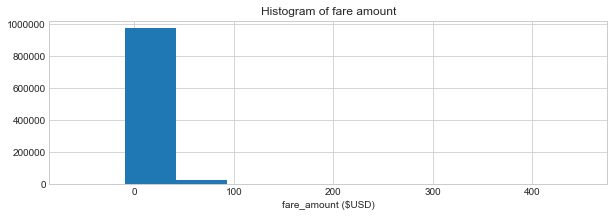

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
sampletrain.fare_amount.hist(bins=10, figsize=(10,3))
plt.xlabel('fare_amount ($USD)')
plt.title('Histogram of fare amount');
plt.show()

In [14]:
# Looks like fare is negative - surely a noisy data, let's drop those rows
print('Original number of rows: %d' % len(sampletrain))
df = sampletrain[sampletrain.fare_amount>0]
print('No. of rows after removing negative fare amount: %d' % len(df))

Original number of rows: 1000000
No. of rows after removing negative fare amount: 999937


In [15]:
# Let's evaluate how many rows have fare greater than 100
df[df.fare_amount>100].describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
count,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000
mean,-67.276302,37.103753,-66.426684,36.664408,1.385075,137.148866
std,21.131734,11.654829,22.360552,12.342200,0.857034,46.141356
min,-74.435527,0.000000,-74.535058,0.000000,1.000000,100.200000
25%,-73.988071,40.664254,-74.171242,40.690323,1.000000,109.790000
50%,-73.874480,40.750108,-73.963578,40.745679,1.000000,120.000000
75%,-73.783853,40.771797,-73.620004,40.900874,1.000000,150.000000
max,0.000000,41.304762,0.000000,41.304762,6.000000,450.000000


**Out of close to 1 million rows there are 335 rows where fare_amount is more than 100 dollars. To have better picture of fare distribution, let's plot histogram of those rows where fare is less than 100.**

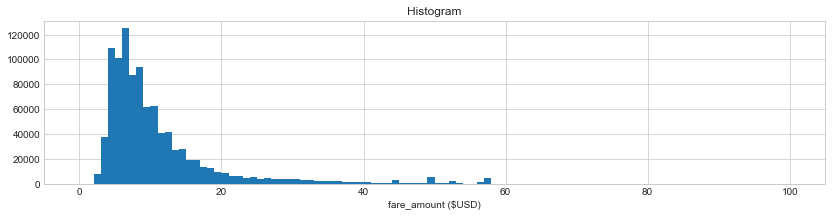

In [16]:
# let's take insight of the Y - Fare 
df[df.fare_amount<100].fare_amount.hist(bins=100, figsize=(14,3))
plt.xlabel('fare_amount ($USD)')
plt.title('Histogram');

## Dealing with missing values

Here we have enormous amount of data, best approach to deal with missing data would be to drop rows where any column has a null or nan values. 

In [17]:
df.isnull().sum()

pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    4
dropoff_latitude     4
passenger_count      0
fare_amount          0
dtype: int64

In [18]:
print('Original number of rows: %d' % len(df))
df = df.dropna(how = 'any', axis = 'rows')
print('No. of rows after dropping missing values: %d' % len(df))

Original number of rows: 999937
No. of rows after dropping missing values: 999933


## Removing Outliers

In [19]:
# Lets review the stat after removal of NAN values
df.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
count,999933.000000,999933.000000,999933.000000,999933.000000,999933.000000,999933.000000
mean,-72.494863,39.920092,-72.498928,39.912199,1.686261,11.337401
std,12.200107,11.563771,13.225837,11.549967,1.325425,9.719923
min,-2053.689307,-3441.914335,-3003.016195,-3441.914335,0.000000,0.010000
25%,-73.992063,40.734956,-73.991379,40.734066,1.000000,6.000000
50%,-73.981814,40.752644,-73.980141,40.753183,1.000000,8.500000
75%,-73.967096,40.767075,-73.963623,40.768110,2.000000,12.500000
max,2526.488913,3285.747978,3225.513947,3322.091548,208.000000,450.000000


__Looking at the max/min of all the columns, looks like we have outliers on each column. Example, passenger count cannot be 208. To remove the outliers, we will adopt the percentile approach to see if we can filter data with valid range of values.__

__First let's take a look at middle 98 percentile of data.__

In [20]:
low = .01
high = .99
quant_df  = df.quantile([low, high])
print(quant_df)

      pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0.01        -74.014264         0.000000         -74.015237          0.000000   
0.99          0.000000        40.806813           0.000000         40.830765   

      passenger_count  fare_amount  
0.01              1.0          3.3  
0.99              6.0         52.5  


We still see outliers in the latitude and longitude columns. 

__So, let's now try for middle 96 percentile of data.__ 

In [21]:
low = .02
high = .98
quant_df  = df.quantile([low, high])
print(quant_df)

      pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0.02        -74.010257        40.566743         -74.011853         40.545672   
0.98        -73.137393        40.799663         -73.137393         40.810127   

      passenger_count  fare_amount  
0.02              1.0         3.50  
0.98              6.0        46.83  


As per http://www.nyc.gov/html/tlc/html/passenger/taxicab_rate.shtml#GroupRideInformation, the minimum fare for a taxi ride cannot be less than $\$2.5$. The percentile approach gives us minimum fare as $\$3.5$.

In [22]:
print('Original number of rows: %d' % len(df))
data_prepared = df[(df.fare_amount>=df.fare_amount.quantile(low))
    & (df.fare_amount<=df.fare_amount.quantile(high))
     
    & (df.pickup_longitude >=df.pickup_longitude.quantile(low))
    & (df.pickup_longitude <=df.pickup_longitude.quantile(high))
    
    & (df.pickup_latitude  >=df.pickup_latitude.quantile(low))
    & (df.pickup_latitude  <=df.pickup_latitude.quantile(high))
       
    & (df.dropoff_longitude  >=df.dropoff_longitude.quantile(low))
    & (df.dropoff_longitude  <=df.dropoff_longitude.quantile(high))
       
    & (df.dropoff_latitude  >=df.dropoff_latitude.quantile(low))
    & (df.dropoff_latitude  <=df.dropoff_latitude.quantile(high))
      
    & (df.passenger_count  >=df.passenger_count.quantile(low))
    & (df.passenger_count  <=df.passenger_count.quantile(high))
       
       ]
print('Number of rows after removing outliers: %d' % len(data_prepared))

Original number of rows: 999933
Number of rows after removing outliers: 874468


__Data looks much cleaner now so let's apply this filtering.__

In [23]:
# Lets take a look on stat now
data_prepared.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
count,874468.000000,874468.000000,874468.000000,874468.000000,874468.000000,874468.000000
mean,-73.976850,40.751310,-73.975418,40.750897,1.690947,10.195427
std,0.029143,0.023090,0.028767,0.026104,1.306218,6.740902
min,-74.010257,40.566809,-74.011853,40.546040,1.000000,3.500000
25%,-73.991890,40.738033,-73.991220,40.737152,1.000000,6.000000
50%,-73.982194,40.753590,-73.980738,40.753860,1.000000,8.100000
75%,-73.969698,40.766690,-73.966862,40.767377,2.000000,12.000000
max,-73.183408,40.799662,-73.189983,40.810127,6.000000,46.830000


## Visualize the features 

### Plot a histogram

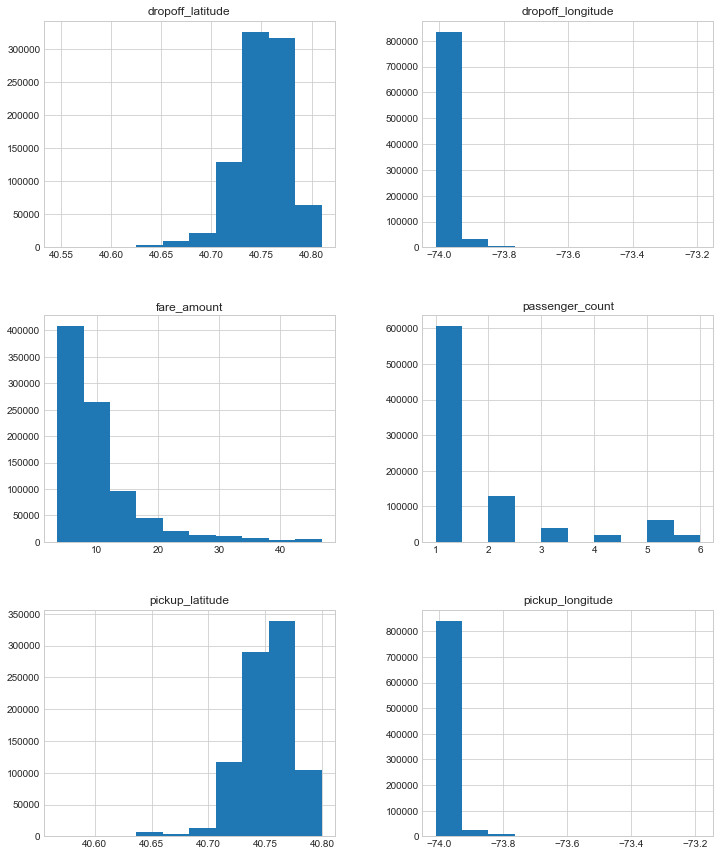

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
data_prepared.hist(bins=10, figsize=(12,15))
plt.show()

### Plot to see if passenger_count is related to target

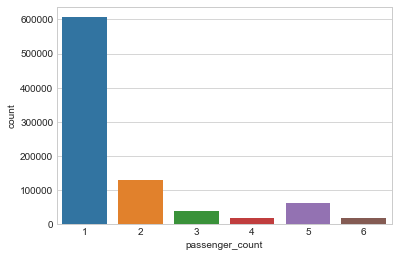

In [25]:
# Count plot on passenger count
sns.countplot(x="passenger_count", data=data_prepared)

In [26]:
passenger_grp = data_prepared.groupby('passenger_count')
passenger_grp['fare_amount'].agg(['mean', 'count'])

,mean,count
passenger_count,,
1,10.112107,606581
2,10.458585,129920
3,10.351840,38870
4,10.376284,18540
5,10.119960,61854
6,10.814877,18703


Plot to see if there is a correlation between the number of passengers and the fare amount.

Text(0.5,1,'Average fare by Passenger count')

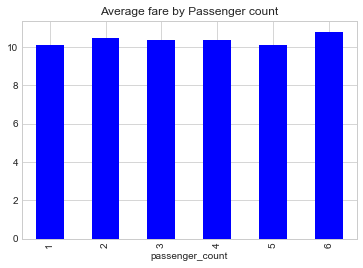

In [27]:
passenger_grp['fare_amount'].mean().plot.bar(color='b');
plt.title('Average fare by Passenger count')

As we can see, there is a small but noticeable difference between the number of passengers and the fare amount. 

### Plot the pick up and drop off locations on NYC Map

We have adopted some of the code for plotting of maps and visualizing the ECDF. Below are the references provided. 

**Reference** <p>
- https://towardsdatascience.com/another-machine-learning-walk-through-and-a-challenge-8fae1e187a64
- https://www.kaggle.com/breemen/nyc-taxi-fare-data-exploration 

In [28]:
# load image of NYC map
# We will use aiblog.nl web service to load the map 
nyc = (-74.5, -72.8, 40.5, 41.8)
nyc_map = plt.imread('https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png')

# Increasing zoom level to see map in a detailed way 
nyc_zoom = (-74.3, -73.7, 40.5, 40.9)
nyc_map_zoom = plt.imread('https://aiblog.nl/download/nyc_-74.3_-73.7_40.5_40.9.png')

In [29]:
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2):
    ''' 
    Function to plot the pickup and dropoff locations on the map.
    input: dataframe, coordinates of NYC, map of the NYC
    output: plots the training data on the map
    
    '''
    fig, axs = plt.subplots(1, 2, figsize=(16,10))
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='y', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)

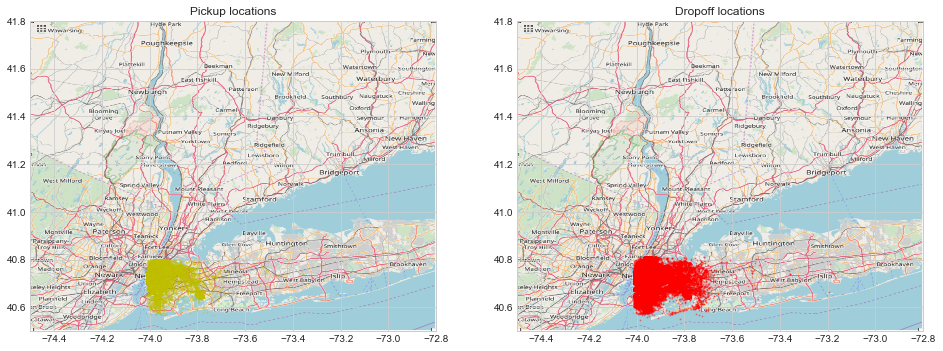

In [30]:
# plot training data on map
plot_on_map(data_prepared, nyc, nyc_map, s=1, alpha=0.3)

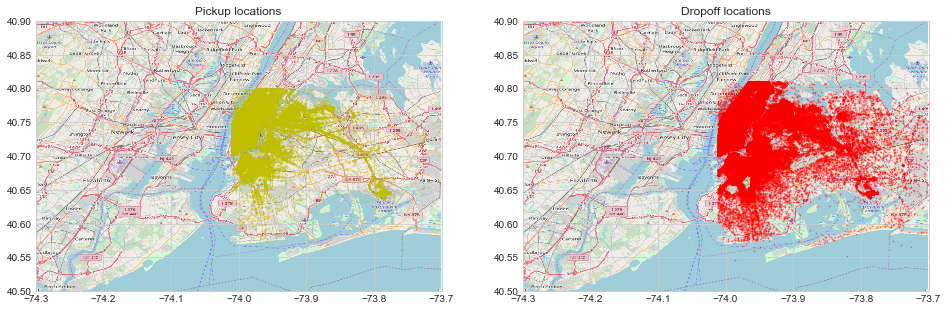

In [31]:
# plot training data on map zoomed in
plot_on_map(data_prepared, nyc_zoom, nyc_map_zoom, s=1, alpha=0.3)

__Main purpose of ploting the data points is to get the good picture of the pickup and dropoff locations. It also validates that our training data points are withn in the boundary of NYC which further help in visualizing the outliers__

### Plot the Empirical cumulative distribution function

The empirical cumulative distribution function provides a graphical representation of the probability distribution of a random vector without implying any prior assumption concerning the form of this distribution. We can view the percentile distribution of the variable and see if there still are any outliers in our target variable. More details about [ECDF](http://openturns.github.io/openturns/master/theory/data_analysis/empirical_cdf.html)

In [32]:
# Declaring CDF fxn 

def ecdf(x):
    """Empirical cumulative distribution function of a variable"""
    # Sort in ascending order
    x = np.sort(x)
    n = len(x)
    
    # Go from 1/n to 1
    y = np.arange(1, n + 1, 1) / n
    
    return x, y

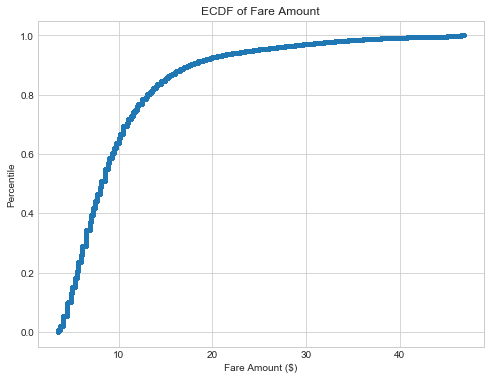

In [33]:
# Visualizing the CDF fxn to check if we still have outliers 
xs, ys = ecdf(data_prepared['fare_amount'])
plt.figure(figsize = (8, 6))
plt.plot(xs, ys, '.')
plt.ylabel('Percentile'); plt.title('ECDF of Fare Amount'); plt.xlabel('Fare Amount ($)');

__CDF graph shows we have close to 90 percentile of data have fare less than or equals to 20 dollars. Please note this is just for one million sample size.__

__Now all columns look much better, let's write a wrapper class which can be utilized in pipeline.__

In [34]:
sampletrain.shape

(1000000, 7)

In [35]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, low=0.02, high=0.98): 
        """

        A class to deal with missing values and remove outliers.

        """
        self.low = low
        self.high = high 
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        
        X = X[X.fare_amount>0]
        
        X = X.dropna(how='any', axis='rows')
        
        X = df[(X.fare_amount >= X.fare_amount.quantile(self.low))
        & (X.fare_amount <= X.fare_amount.quantile(self.high))
     
        & (X.pickup_longitude >= X.pickup_longitude.quantile(self.low))
        & (X.pickup_longitude <= X.pickup_longitude.quantile(self.high))
    
        & (X.pickup_latitude  >= X.pickup_latitude.quantile(self.low))
        & (X.pickup_latitude  <= X.pickup_latitude.quantile(self.high))
       
        & (X.dropoff_longitude  >= X.dropoff_longitude.quantile(self.low))
        & (X.dropoff_longitude  <= X.dropoff_longitude.quantile(self.high))
       
        & (X.dropoff_latitude  >= X.dropoff_latitude.quantile(self.low))
        & (X.dropoff_latitude  <= X.dropoff_latitude.quantile(self.high))
      
        & (X.passenger_count  >= X.passenger_count.quantile(self.low))
        & (X.passenger_count  <= X.passenger_count.quantile(self.high))
       
       ]
        
        return X

In [36]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
        ('data_cleaner', DataCleaner(low=0.02,high=0.98)),
        
    ])

prepared_data = pipeline.fit_transform(sampletrain)

In [37]:
prepared_data.shape

(874468, 7)

In [38]:
prepared_data.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
2,2012-08-11 23:43:19,-73.969091,40.798644,-73.993477,40.757396,1,12.5
3,2014-12-04 20:41:26,-73.999625,40.733399,-73.987364,40.764521,1,14.5
4,2012-03-08 20:40:29,-73.980710,40.782418,-73.968085,40.793062,1,5.3
5,2014-12-19 11:12:00,-74.001232,40.725463,-73.994935,40.743753,1,10.0
6,2009-05-09 13:05:00,-74.000990,40.747675,-73.995413,40.749512,3,4.5


In [39]:
prepared_data.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
count,874468.000000,874468.000000,874468.000000,874468.000000,874468.000000,874468.000000
mean,-73.976850,40.751310,-73.975418,40.750897,1.690947,10.195427
std,0.029143,0.023090,0.028767,0.026104,1.306218,6.740902
min,-74.010257,40.566809,-74.011853,40.546040,1.000000,3.500000
25%,-73.991890,40.738033,-73.991220,40.737152,1.000000,6.000000
50%,-73.982194,40.753590,-73.980738,40.753860,1.000000,8.100000
75%,-73.969698,40.766690,-73.966862,40.767377,2.000000,12.000000
max,-73.183408,40.799662,-73.189983,40.810127,6.000000,46.830000


## Find Correlation

fare_amount          1.000000
pickup_longitude     0.365777
dropoff_longitude    0.364266
passenger_count      0.012424
pickup_latitude     -0.116918
dropoff_latitude    -0.198978
Name: fare_amount, dtype: float64


Text(0.5,1,'Heatmap of Correlation Matrix')

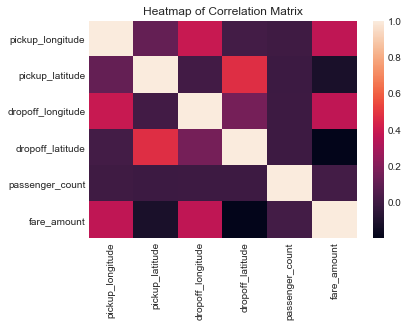

In [40]:
corr_matrix = prepared_data.corr()
print(corr_matrix["fare_amount"].sort_values(ascending=False))
sns.heatmap(corr_matrix, 
            xticklabels=corr_matrix.columns.values,
            yticklabels=corr_matrix.columns.values)
plt.title('Heatmap of Correlation Matrix')

As we have a limited set of features, the correlation plot shows that longitude is most highly correlated with the target column.

# Feature Engineering

The below class is used for deriving new features out of our existing numerical features. For this phase, we are deriving the timestamp related features (hour, day, month and year) and distance features using Haversine formula based on latitude and longitude columns. The haversine formula determines the great-circle distance between two points on a sphere given their longitudes and latitudes. And the great-circle distance or orthodromic distance is the shortest distance between two points on the surface of a sphere, measured along the surface of the sphere (as opposed to a straight line through the sphere's interior). More [info here](https://en.wikipedia.org/wiki/Haversine_formula)

In [41]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
datetime_ix, lon1_ix, lat1_ix, lon2_ix, lat2_ix = 0, 1, 2, 3, 4

# Radius of the earth in kilometers
R = 6378

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        """

        A class to derive new features from numerical features.

        """
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X, y=None):
        def extract_date(X_val, dt_ix):
            h = [t.hour for t in pd.DatetimeIndex(X_val[:, dt_ix])]
            d = [t.dayofweek for t in pd.DatetimeIndex(X_val[:, dt_ix])]
            m = [t.month for t in pd.DatetimeIndex(X_val[:, dt_ix])]
            y = [t.year for t in pd.DatetimeIndex(X_val[:, dt_ix])]
            return h, d, m, y
        
        # Calculate distance between pickup and dropoff using Haversine formula
        def haversine_np(X_val, lon1_idx, lat1_idx, lon2_idx, lat2_idx, r):
            """
            Calculate the great circle distance between two points
            on the earth (specified in decimal degrees)

            All args must be of equal length.    

            source: https://stackoverflow.com/a/29546836

            """
            lon1 = X_val[:, lon1_idx].astype(float)
            lat1 = X_val[:, lat1_idx].astype(float)
            lon2 = X_val[:, lon2_idx].astype(float)
            lat2 = X_val[:, lat2_idx].astype(float)
 
            # Convert latitude and longitude to radians
            lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    
            # Find the differences
            dlon = lon2 - lon1
            dlat = lat2 - lat1

            # Apply the formula 
            a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
            # Calculate the angle (in radians)
            c = 2 * np.arcsin(np.sqrt(a))
            # Convert to kilometers
            km = r * c

            return km
        
        hour, day, month, year = extract_date(X, datetime_ix)
        distance = haversine_np(X, lon1_ix, lat1_ix, lon2_ix, lat2_ix, R)
        X = np.delete(X, 0, axis=1)
        return np.c_[X, hour, day, month, year, distance]

In [42]:
num_attribs = ['pickup_datetime',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'passenger_count',
 'fare_amount', 
    ]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

sampletrain_prepared = num_pipeline.fit_transform(prepared_data)

In [43]:
sampletrain_prepared.shape

(874468, 11)

In [44]:
train_prepared = pd.DataFrame(data=sampletrain_prepared, 
                  columns=['pickup_longitude', 'pickup_latitude', 
                           'dropoff_longitude', 'dropoff_latitude', 'passenger_count','fare_amount', 'hour', 'day', 'month', 'year', 'distance'])

In [45]:
train_prepared.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,hour,day,month,year,distance
0,0.266239,2.049997,-0.627748,0.248970,-0.528968,0.341879,1.448049,1.005290,0.504300,0.140437,0.814114
1,-0.781493,-0.775710,-0.415250,0.521914,-0.528968,0.638576,0.988016,-0.020965,1.666322,1.212533,0.275204
2,-0.132451,1.347262,0.254919,1.615259,-0.528968,-0.726228,0.988016,-0.020965,-0.948226,0.140437,-0.495052
3,-0.836635,-1.119412,-0.678430,-0.273664,-0.528968,-0.028991,-0.392083,0.492163,1.666322,1.212533,-0.300246
4,-0.828332,-0.157429,-0.695046,-0.053049,1.002171,-0.844906,-0.085394,1.005290,-0.367215,-1.467707,-0.906156


## Find correlation after feature engineering

In [46]:
corr_matrix = train_prepared.corr()

In [47]:
corr_matrix = train_prepared.corr()
corr_matrix["fare_amount"].sort_values(ascending=False)

fare_amount          1.000000
distance             0.860217
pickup_longitude     0.365777
dropoff_longitude    0.364266
year                 0.110211
month                0.027278
passenger_count      0.012424
day                  0.006093
hour                -0.015716
pickup_latitude     -0.116918
dropoff_latitude    -0.198978
Name: fare_amount, dtype: float64

Text(0.5,1,'Heatmap of Correlation Matrix')

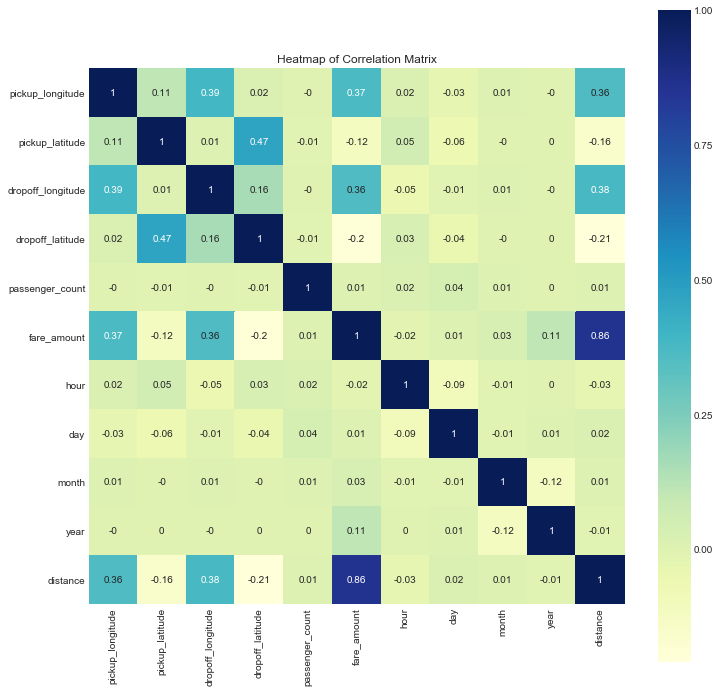

In [48]:
plt.figure(figsize = (12, 12))
sns.heatmap(np.round(corr_matrix, 2), square=True, annot=True, cmap="YlGnBu",
            xticklabels=corr_matrix.columns.values,
            yticklabels=corr_matrix.columns.values)
plt.title('Heatmap of Correlation Matrix')

As we see from above heatmap, that distance is highly correlated with fare_amount followed by longitude columns.

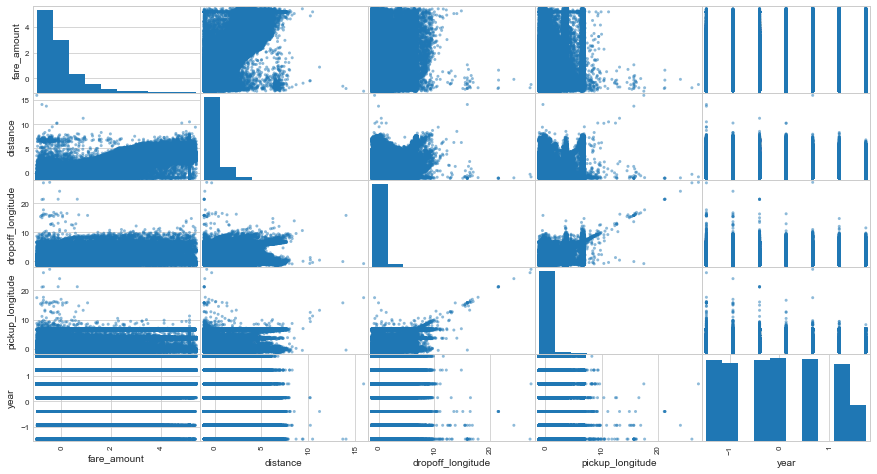

In [49]:
from pandas.plotting import scatter_matrix

# Top four correlated inputs with fare_amount
attributes = ["fare_amount", "distance", "dropoff_longitude", "pickup_longitude", "year"]
scatter_matrix(train_prepared[attributes], figsize=(15, 8));

# Feature Selection

## Using SelectKBest technique

In [50]:
train_prepared.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,hour,day,month,year,distance
0,0.266239,2.049997,-0.627748,0.248970,-0.528968,0.341879,1.448049,1.005290,0.504300,0.140437,0.814114
1,-0.781493,-0.775710,-0.415250,0.521914,-0.528968,0.638576,0.988016,-0.020965,1.666322,1.212533,0.275204
2,-0.132451,1.347262,0.254919,1.615259,-0.528968,-0.726228,0.988016,-0.020965,-0.948226,0.140437,-0.495052
3,-0.836635,-1.119412,-0.678430,-0.273664,-0.528968,-0.028991,-0.392083,0.492163,1.666322,1.212533,-0.300246
4,-0.828332,-0.157429,-0.695046,-0.053049,1.002171,-0.844906,-0.085394,1.005290,-0.367215,-1.467707,-0.906156


In [51]:
from sklearn.feature_selection import SelectKBest, f_regression
y = train_prepared['fare_amount']
X = train_prepared.drop(['fare_amount'], axis=1)

In [52]:
print(X.shape)
print(y.shape)

(874468, 10)
(874468,)


In [53]:
X.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,distance
0,0.266239,2.049997,-0.627748,0.248970,-0.528968,1.448049,1.005290,0.504300,0.140437,0.814114
1,-0.781493,-0.775710,-0.415250,0.521914,-0.528968,0.988016,-0.020965,1.666322,1.212533,0.275204
2,-0.132451,1.347262,0.254919,1.615259,-0.528968,0.988016,-0.020965,-0.948226,0.140437,-0.495052
3,-0.836635,-1.119412,-0.678430,-0.273664,-0.528968,-0.392083,0.492163,1.666322,1.212533,-0.300246
4,-0.828332,-0.157429,-0.695046,-0.053049,1.002171,-0.085394,1.005290,-0.367215,-1.467707,-0.906156


In [54]:
from sklearn.feature_selection import SelectKBest, f_regression

# SCORE  linear regression input variables using correlation producing F scores and corresponding p-values
# K is used select top k rated input features
def select_kbest_reg(data_frame, target, k=5):
    """
    Selecting K-Best features regression
    :param data_frame: A pandas dataFrame with the training data
    :param target: target variable name in DataFrame
    :param k: desired number of features from the data
    :returns feature_scores: scores for each feature in the data as 
    pandas DataFrame
    """
    feat_selector = SelectKBest(f_regression, k=k)
    _ = feat_selector.fit(data_frame.drop(target, axis=1), data_frame[target])
    
    feat_scores = pd.DataFrame()
    feat_scores["F Score"] = feat_selector.scores_
    feat_scores["P Value"] = feat_selector.pvalues_
    feat_scores["Support"] = feat_selector.get_support()
    feat_scores["Attribute"] = data_frame.drop(target, axis=1).columns
    
    return feat_scores

In [55]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

df = pd.DataFrame(X_train, columns=X_train.columns).copy()
df["fare_amount"] = y_train

per_feat = select_kbest_reg(df, 'fare_amount', k=6)
per_feat_sorted = per_feat.sort_values(["F Score", "P Value"], ascending=[False, False])
top_k_feature_indices = per_feat_sorted['Attribute'].values.flatten()
print("\n Feature Score for a linear regression using correlation\n")
print(per_feat_sorted)   

#print(np.linalg.norm(y_train))


 Feature Score for a linear regression using correlation

        F Score        P Value  Support          Attribute
9  1.986034e+06   0.000000e+00     True           distance
0  1.071608e+05   0.000000e+00     True   pickup_longitude
2  1.069375e+05   0.000000e+00     True  dropoff_longitude
3  2.857348e+04   0.000000e+00     True   dropoff_latitude
1  9.682635e+03   0.000000e+00     True    pickup_latitude
8  8.578782e+03   0.000000e+00     True               year
7  4.752072e+02  2.557569e-105    False              month
5  1.687439e+02   1.405986e-38    False               hour
4  1.116963e+02   4.183580e-26    False    passenger_count
6  2.455670e+01   7.217172e-07    False                day


The features that are selected by SelectKBest are the same features that were also most highly correlated, which were shown on finding the correlation using heatmap. 

# Model Evaluation

## train test split

Lets split sample training dataset into train and validation sets for experimentation purpose. We will train our models on train part and validate against val part.

In [56]:
y = prepared_data['fare_amount']
X = prepared_data.drop(['fare_amount'], axis=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [57]:
X_train.shape,y_train.shape,X_val.shape,y_val.shape

((699574, 6), (699574,), (174894, 6), (174894,))

## Building Pipeline

Lets create a full pipeline with predictor. <p>
This pipeline will - 
    - create additional features
    - stardardize data with mean of zero and std.deviation of one.  
    - run predictor on transformed data.

In [58]:
num_attribs = ['pickup_datetime',
                    'pickup_longitude',
                    'pickup_latitude',
                    'dropoff_longitude',
                    'dropoff_latitude',
                    'passenger_count',
                    ]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

full_pipeline_with_predictor = Pipeline([
        ("preparation", num_pipeline),
        ("predictor", LinearRegression())
        ])

## Baseline model LinearRegression

Let's benchmark our results with vanilla Linear Regression Model. 

In [59]:
from time import time

start = time()
full_pipeline_with_predictor.fit(X_train, y_train)

# Time and score training predictions
cv = ShuffleSplit(n_splits=30, test_size=0.3, random_state=0)
lin_scores = cross_val_score(full_pipeline_with_predictor, X_train, y_train,scoring="neg_mean_squared_error", cv=cv)
lin_score_train = np.sqrt(-lin_scores.mean())
train_time = np.round(time() - start, 4)

# Time and score test predictions
start = time()
X_val_prediction = full_pipeline_with_predictor.predict(X_val)
lin_score_mse  = mean_squared_error(y_val, X_val_prediction)
lin_score_test = np.sqrt(lin_score_mse)
test_time = np.round(time() - start, 4)

In [60]:
results.loc[0] = ["Baseline", lin_score_train, lin_score_test, 
                  "---","---", train_time, test_time, "Untuned LinearRegression"]
results 

,ExpID,Train RMSE,Test RMSE,p-value,t-stat,Train Time(s),Test Time(s),Experiment description
0,Baseline,3.294018,3.280255,---,---,170.3835,1.3439,Untuned LinearRegression


## Hyperparameter Tuning using GridSearchCV,  and Statistical significance tests

Now, let's create a wrapper method, which will : <p>
    - execute full pipeline with predictor
    - perform GridSearch for given set of parameters 
    - report best set of parameters
    - calculate RMSE
    - perform t-test with best estimator set
    - populate results table

In [61]:
# A Function to execute the grid search and record the results.
def ConductGridSearch(X_train, y_train, X_val, y_val, i=0, prefix=''):
    
    # Create a list of regressors for our grid search experiment
    regressors = [
        ('RandomForestRegressor', RandomForestRegressor(random_state=42,n_jobs=-1)),
    ]
    
    num_attribs = ['pickup_datetime',
                    'pickup_longitude',
                    'pickup_latitude',
                    'dropoff_longitude',
                    'dropoff_latitude',
                    'passenger_count',
                    ]

    # Arrange grid search parameters for each regressor
    params_grid = {
        'RandomForestRegressor': {
            'n_estimators': (3, 10, 30),
            'max_features': [2, 4, 6], 
        },
    }
    
    for (name, regressor) in regressors:
        i += 1
        # Print regressor and parameters
        print('****** START',prefix, name,'*****')
        parameters = params_grid[name]
        print("Parameters:")
        for p in sorted(parameters.keys()):
            print("\t"+str(p)+": "+ str(parameters[p]))
        
        # generate the pipeline
        num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
        ])
        
        full_pipeline_with_predictor = Pipeline([
        ("preparation", num_pipeline),
        ("predictor", regressor)
        ])
        
        # Execute the grid search
        params = {}
        for p in parameters.keys():
            pipe_key = 'predictor__'+str(p)
            params[pipe_key] = parameters[p] 
            
        grid_search = GridSearchCV(full_pipeline_with_predictor, params, scoring='neg_mean_squared_error', cv=5, verbose=1)
        grid_search.fit(X_train, y_train)
                
        # Best estimator score
        best_train = grid_search.best_score_
        best_train_score = np.sqrt(-best_train)

        # Best estimator fitting time
        start = time()
        grid_search.best_estimator_.fit(X_train, y_train)
        train_time = round(time() - start, 4)

        # Best estimator prediction time
        start = time()
        X_val_prediction = grid_search.best_estimator_.predict(X_val)
        best_score_mse  = mean_squared_error(y_val, X_val_prediction)
        best_test_rmse = np.sqrt(best_score_mse)
        test_time = round(time() - start, 4)

        # Generate 30 training mse scores with the best estimator and 30-split CV
        cv = ShuffleSplit(n_splits=30, test_size=0.3, random_state=0)
        best_train_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train,scoring='neg_mean_squared_error', cv=cv)
        best_train_rmse = np.sqrt(-best_train_scores.mean())

        # Conduct t-test with baseline lin_reg (control) and best estimator (experiment)
        (t_stat, p_value) = stats.ttest_rel(lin_scores, best_train_scores)
        if p_value > 0.05/2:  #Two sided 
            print('There is no significant difference between the two machine learning pipelines (Accept H0)')
        else:
            print('The two machine learning pipelines are different (reject H0) \n(t_stat, p_value) = (%.2f, %.5f)'%(t_stat, p_value) )
            if t_stat > 0.0: #in the case of regression lower RMSE is better; A is lower 
                print('Machine learning pipeline A is better than B')
            else:
                print('Machine learning pipeline B is better than A')
        
        
        # Collect the best parameters found by the grid search
        print("Best Parameters:")
        best_parameters = grid_search.best_estimator_.get_params()
        param_dump = []
        for param_name in sorted(params.keys()):
            param_dump.append((param_name, best_parameters[param_name]))
            print("\t"+str(param_name)+": " + str(best_parameters[param_name]))
        print("****** FINISH",prefix,name," *****")
        print("")
        
        # Record the results
        results.loc[i] = [prefix+name, best_train_rmse, best_test_rmse, round(p_value,3),round(t_stat,3), train_time, test_time, json.dumps(param_dump)]

Performing GridSearch with wrapper method

In [62]:
%%time
# This might take a while
ConductGridSearch(X_train,y_train,X_val,y_val, 0, "Best Model:") 

****** START Best Model: RandomForestRegressor *****
Parameters:
	max_features: [2, 4, 6]
	n_estimators: (3, 10, 30)
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 12.2min finished


The two machine learning pipelines are different (reject H0) 
(t_stat, p_value) = (-378.33, 0.00000)
Machine learning pipeline B is better than A
Best Parameters:
	predictor__max_features: 4
	predictor__n_estimators: 30
****** FINISH Best Model: RandomForestRegressor  *****

Wall time: 20min 55s


### Experiment Results Table

In [63]:
results

,ExpID,Train RMSE,Test RMSE,p-value,t-stat,Train Time(s),Test Time(s),Experiment description
0,Baseline,3.294018,3.280255,---,---,170.3835,1.3439,Untuned LinearRegression
1,Best Model:RandomForestRegressor,2.577578,2.526037,0,-378.325,19.5216,1.9270,"[[""predictor__max_features"", 4], [""predictor__..."


## Discussion 

Above result table captures details about our experiments. It has :
    - RMSE values which is our performance criteria. 
    - p-value which tells if the experiment result is different than our baseline model. 
    - t-score which tells which model is better 
    - time taken for execution
    
**Results table shows that**

- **Best model is - RandomForestRegressor max_features=4,n_estimators=30**
- Test RMSE value shows that we are able to predict the taxi fare with +/- \$2.5 difference.
- RandomForestRegressor is performing better than LinearRegression. It is also evident from RMSE scores of two models. 
- From comparison between train and test RMSE shows that our model is optimum fitted. NO overfitting or underfitting observed.

## Validation set prediction with Best Model

In [64]:
best_model = RandomForestRegressor(random_state=42,n_jobs=-1,max_features=4,n_estimators=30)
full_pipeline_with_bestmodel = Pipeline([
        ("preparation", num_pipeline),
        ("predictor", best_model)
        ])
full_pipeline_with_bestmodel.fit(X_train, y_train)
x_val_predictions = full_pipeline_with_bestmodel.predict(X_val)

(array([76809., 57169., 21341.,  8151.,  3357.,  2432.,  2384.,  1675.,
         1115.,   461.]),
 array([ 3.69666667,  7.842     , 11.98733333, 16.13266667, 20.278     ,
        24.42333333, 28.56866667, 32.714     , 36.85933333, 41.00466667,
        45.15      ]),
 <a list of 10 Patch objects>)

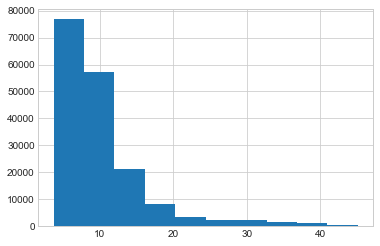

In [65]:
plt.hist(x_val_predictions)

## Feature Importance

Lets see which features contributed to Best models accuracy

In [66]:
feature_importances = full_pipeline_with_bestmodel.named_steps.predictor.feature_importances_
feature_importances

array([0.11725313, 0.04215702, 0.11602904, 0.06033908, 0.00490871,
       0.01957419, 0.00977454, 0.01255418, 0.02863841, 0.58877171])

In [67]:
attributes = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude','dropoff_latitude','passenger_count', 'hour', 'day', 'month', 'year', 'distance']
sortedFeatures = sorted(zip(feature_importances, attributes), reverse=False)

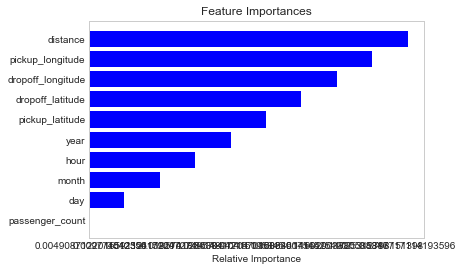

In [68]:
# Plot the feature importances of the forest
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.figure() 
plt.title("Feature importances")
sortedNames = np.array(sortedFeatures)[:, 1]
sortedImportances = np.array(sortedFeatures)[:, 0]

plt.title('Feature Importances')
plt.barh(range(len(sortedNames)), sortedImportances, color='b', align='center')
plt.yticks(range(len(sortedNames)), sortedNames)
plt.xlabel('Relative Importance')
plt.grid()
plt.show()

Above graph shows that distance, pickup_longitude, dropoff_longitude, dropoff_latitude, pickup_latitude, year contributed heavily towards model accuracy. This results are in-line with our select K-best feature selection output.

# Test Data Predictions 

Moment of Truth !! <p>
We have experimented and  trained our model with best parameters , validated against val set.<p>
Now we have to see how it works on actual test data.

In [69]:
x_test=test.drop(['key'],axis=1)

In [70]:
x_test.columns

Index(['pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count'],
      dtype='object')

In [71]:
predictions = full_pipeline_with_bestmodel.predict(x_test)

(array([4103., 3087., 1221.,  568.,  252.,  215.,  184.,  128.,   92.,
          64.]),
 array([ 3.76666667,  7.9       , 12.03333333, 16.16666667, 20.3       ,
        24.43333333, 28.56666667, 32.7       , 36.83333333, 40.96666667,
        45.1       ]),
 <a list of 10 Patch objects>)

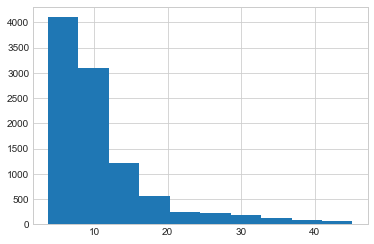

In [72]:
plt.hist(predictions)

## Kaggle Submission

In [73]:
submission = pd.DataFrame(
    {'key': test.key, 'fare_amount': predictions},
    columns = ['key', 'fare_amount'])
submission.to_csv('submission.csv', index = False)

![title](image/1MPhase1.png)

# Next Steps - Phase 2

Further work needs to be done on the dataset to achieve better accuracies. Potential steps for next phase -
- **Scale up**
    - Use more data as training set. Gradually we will use in steps of 5million, 10 million, ... considering our compute power.
- **Data Cleanup** 
    - We will use 99 percentile of training dataset.
    - Remove geo locations falling in water area. 
- **EDA**
    - See if the hour of the time makes a difference on the fare amount
    - Find out if the day of the week makes an impact on the fare amount
- **Feature Engineering**
    - Addition of new features like travel direction, late night travels, experiment with different types of distances, etc. 
    - perform PCA to find out best set of features
- **Model Evaluation**
    - We will try new models like SupportVectorRegressor etc
    - Randomized Search for evaluating range of parameters